In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
game_reviews = pd.read_csv("all_Steam_Reviews_cleaned_1.csv")
pos_reviews=pd.read_csv("positive_steam_reviews_1.csv")
neg_reviews=pd.read_csv("negative_steam_reviews_1.csv")

In [3]:
pos_reviews

,game,review,recommended,genre,action,strategy,free_to_play,adventure,massively_multiplayer,indie,...,casual,racing,early_access,simulation,unknown_genre,sports,violent,education,utilities,cleaned_review
0,Company of Heroes 3,Here is my actual review. COH3 has the best Qo...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,actual review good qol franchise stop play fav...
1,Company of Heroes 3,I resisted for quite a while to buy this game ...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,resist buy game not expect game different fina...
2,Company of Heroes 3,Final Thoughts\nCompany of Heroes 3 is a stunn...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,final thought company heroe stunning evolution...
3,Company of Heroes 3,game has come a long way since release but can...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,game come long way release feel like cash grab...
4,Company of Heroes 3,A great RTS that is going to get better with e...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,great rt go well major update time start play ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34040,Baldur's Gate 3,It's not just a game! It's a whole story that ...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,game story completely immerse primarily thank ...
34041,Baldur's Gate 3,It's the closest you're going to get to playin...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,close go play dnd group friend willing sit pla...
34042,Baldur's Gate 3,verry gooood gammeeee. I slept on it for to lo...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,verry gooood gammeeee sleep long finish ton co...
34043,Baldur's Gate 3,Funny wild magic sorceror Durge run made every...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,funny wild magic sorceror durge run turn cat t...


In [4]:
#avoid error later
pos_reviews.rename(columns={'game': 'Game'}, inplace=True)
neg_reviews.rename(columns={'game': 'Game'}, inplace=True)
game_reviews.rename(columns={'game': 'Game'}, inplace=True)



In [5]:
game_reviews.columns

Index(['Game', 'review', 'recommended', 'genre', 'action', 'strategy',
       'free_to_play', 'adventure', 'massively_multiplayer', 'indie', 'rpg',
       'casual', 'racing', 'early_access', 'simulation', 'unknown_genre',
       'sports', 'violent', 'education', 'utilities', 'cleaned_review'],
      dtype='object')

In [6]:
# Drop NaNs and remove custom stopwords
'''
custom_stopwords = {
    "ve", "re", "want", "try", "new", "work", "need", "thing", "buy", "fix", 
    "hour", "long", "gameplay", "update", "dlc", "player", "pay",
    'time', 'game', 'play', 'good', 'great', 'bad', 'like', 'fun', 
    'best', 'better', 'enjoy', 'recommend', 'yes', "feel", "lot", "come", "way", "nice", "ha", "think",
    "aight", "haha", "gobagool", "goate", "unsuur", "jyjtyjtukutk"
}

def remove_custom_stopwords(text):
    tokens = text.split()
    filtered = [t for t in tokens if t.lower() not in custom_stopwords]
    return " ".join(filtered)
'''

# Clean reviews
pos_reviews = pos_reviews.dropna(subset=["cleaned_review"])
neg_reviews = neg_reviews.dropna(subset=["cleaned_review"])

#pos_reviews["cleaned_review"] = pos_reviews["cleaned_review"].apply(remove_custom_stopwords)
#neg_reviews["cleaned_review"] = neg_reviews["cleaned_review"].apply(remove_custom_stopwords)

# Group reviews by game 
# This creates ONE document per game (concatenating all reviews)
grouped_pos = pos_reviews.groupby("Game")["cleaned_review"].apply(lambda x: " ".join(x)).reset_index()
grouped_neg = neg_reviews.groupby("Game")["cleaned_review"].apply(lambda x: " ".join(x)).reset_index()

# TF-IDF for positive reviews 
vectorizer_pos = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)
tfidf_matrix_pos = vectorizer_pos.fit_transform(grouped_pos["cleaned_review"])
terms_pos = vectorizer_pos.get_feature_names_out()
top_words_pos = tfidf_matrix_pos.toarray().argsort(axis=1)[:, -10:][:, ::-1]  # Top 10 per row

# TF-IDF for negative reviews
vectorizer_neg = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)
tfidf_matrix_neg = vectorizer_neg.fit_transform(grouped_neg["cleaned_review"])
terms_neg = vectorizer_neg.get_feature_names_out()
top_words_neg = tfidf_matrix_neg.toarray().argsort(axis=1)[:, -10:][:, ::-1]

# Convert to lists of top terms
top_pos_words = [[terms_pos[i] for i in row] for row in top_words_pos]
top_neg_words = [[terms_neg[i] for i in row] for row in top_words_neg]

df_top_words = pd.DataFrame({
    "Game": grouped_pos["Game"],
    "Top_Positive_Words": top_pos_words
}).merge(
    pd.DataFrame({
        "Game": grouped_neg["Game"],
        "Top_Negative_Words": top_neg_words
    }),
    on="Game",
    how="outer"
)

df_top_words.to_csv("game_top_tfidf_words_by_doc.csv", index=False)
df_top_words.head()


,Game,Top_Positive_Words,Top_Negative_Words
0,0 Day,"[devs love, game wait, devs, wait, love game, ...",NaN
1,100% Orange Juice,"[dice, mario party, juice, game, mario, orange...","[dream hell, highpitche continuous, shorter an..."
2,ARK: Survival Ascended,"[game, ark, ascend, play, good, like, server, ...","[game, ark, ase, wildcard, server, survival, e..."
3,ARK: Survival Evolved,"[game, dinosaur, play, good, fun, dino, ark, t...","[game, play, server, ark, time, like, dino, wi..."
4,Age of Empires II: Definitive Edition,"[game, rt, good, play, aoe, good rt, classic, ...","[game, unit, civilization, internet, play, bug..."


In [7]:
for index, row in df_top_words.iterrows():
    print(f"{row['Game']} - Positive Words: {row['Top_Positive_Words']}")

0 Day - Positive Words: ['devs love', 'game wait', 'devs', 'wait', 'love game', 'love', 'game', 'game balance', 'game age', 'game add']
100% Orange Juice - Positive Words: ['dice', 'mario party', 'juice', 'game', 'mario', 'orange juice', 'roll', 'dice roll', 'rng', 'party']
ARK: Survival Ascended - Positive Words: ['game', 'ark', 'ascend', 'play', 'good', 'like', 'server', 'mod', 'dinosaur', 'time']
ARK: Survival Evolved - Positive Words: ['game', 'dinosaur', 'play', 'good', 'fun', 'dino', 'ark', 'tame', 'like', 'server']
Age of Empires II: Definitive Edition - Positive Words: ['game', 'rt', 'good', 'play', 'aoe', 'good rt', 'classic', 'strategy', 'strategy game', 'definitive edition']
Age of Empires IV: Anniversary Edition - Positive Words: ['game', 'age empire', 'aoe', 'rt', 'empire', 'good', 'play', 'age', 'civilization', 'civ']
Artifact - Positive Words: ['valve', 'murder', 'great game', 'great', 'game', 'zone', 'game amazing', 'game addictive', 'game age', 'game allow']
Assassin's

In [8]:
for index, row in df_top_words.iterrows():
    print(f"{row['Game']} - Negative Words: {row['Top_Negative_Words']}")

0 Day - Negative Words: nan
100% Orange Juice - Negative Words: ['dream hell', 'highpitche continuous', 'shorter annoying', 'moaning', 'moaning ear', 'ladder instead', 'hear highpitche', 'work hear', 'play number', 'highpitche']
ARK: Survival Ascended - Negative Words: ['game', 'ark', 'ase', 'wildcard', 'server', 'survival', 'evolve', 'play', 'crash', 'ark survival']
ARK: Survival Evolved - Negative Words: ['game', 'play', 'server', 'ark', 'time', 'like', 'dino', 'wildcard', 'fun', 'snail']
Age of Empires II: Definitive Edition - Negative Words: ['game', 'unit', 'civilization', 'internet', 'play', 'bug', 'time', 'new', 'connection', 'delete game']
Age of Empires IV: Anniversary Edition - Negative Words: ['game', 'aoe', 'empire', 'play', 'age', 'like', 'player', 'skilled', 'historical', 'opponent']
Artifact - Negative Words: nan
Assassin's Creed® Origins - Negative Words: ['ubisoft', 'game', 'connect', 'ubisoft connect', 'play', 'quest', 'ac', 'open world', 'pretty', 'open']
Atomic Hear

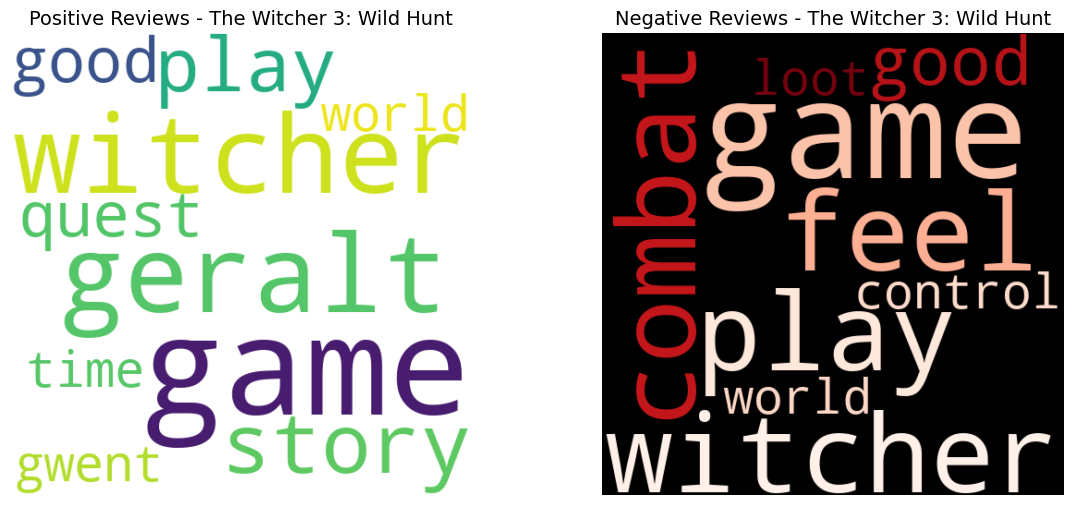

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Select a game for visualization
selected_game = "The Witcher 3: Wild Hunt"  # Change this to any game you want

# Extract positive and negative words for the selected game
game_data = df_top_words[df_top_words["Game"] == selected_game]

if not game_data.empty:
    pos_words = game_data["Top_Positive_Words"].values[0]
    neg_words = game_data["Top_Negative_Words"].values[0]

    # Convert lists to space-separated strings
    pos_text = " ".join(pos_words)
    neg_text = " ".join(neg_words)

    # Create figure for side-by-side word clouds
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Generate Positive Word Cloud
    wordcloud_pos = WordCloud(width=500, height=500, background_color="white").generate(pos_text)
    axes[0].imshow(wordcloud_pos, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"Positive Reviews - {selected_game}", fontsize=14)

    # Generate Negative Word Cloud
    wordcloud_neg = WordCloud(width=500, height=500, background_color="black", colormap="Reds").generate(neg_text)
    axes[1].imshow(wordcloud_neg, interpolation="bilinear")
    axes[1].axis("off")
    axes[1].set_title(f"Negative Reviews - {selected_game}", fontsize=14)

    # Show the word clouds
    plt.show()
else:
    print(f"No data found for {selected_game}")


In [10]:
df_top_words

,Game,Top_Positive_Words,Top_Negative_Words
0,0 Day,"[devs love, game wait, devs, wait, love game, ...",NaN
1,100% Orange Juice,"[dice, mario party, juice, game, mario, orange...","[dream hell, highpitche continuous, shorter an..."
2,ARK: Survival Ascended,"[game, ark, ascend, play, good, like, server, ...","[game, ark, ase, wildcard, server, survival, e..."
3,ARK: Survival Evolved,"[game, dinosaur, play, good, fun, dino, ark, t...","[game, play, server, ark, time, like, dino, wi..."
4,Age of Empires II: Definitive Edition,"[game, rt, good, play, aoe, good rt, classic, ...","[game, unit, civilization, internet, play, bug..."
...,...,...,...
92,Valheim,"[game, valheim, play, survival, survival game,...","[game, biome, boss, ashland, valheim, time, mi..."
93,"Warhammer 40,000: Space Marine 2","[game, marine, space marine, warhammer, empero...","[game, marine, space marine, play, campaign, o..."
94,Windblown,"[game, dead cell, cell, play, windblown, early...","[dead cell, cell, motion twin, dead, twin, gam..."
95,X-Morph: Defense,"[tower defense, defense, tower, turret, game, ...","[default screen, screen, default, set, set gam..."


As we can see the words have some like "game", "good", "play", "great", "bad" that doesnt really say nothing to us, therefore we have to add them to a stopword list to remove them.

In [11]:
# Drop NaNs and remove custom stopwords

custom_stopwords = {
    "ve", "re", "want", "try", "new", "work", "need", "thing", "buy", "fix", 
    "hour", "long", "gameplay", "update", "dlc", "player", "pay",
    'time', 'game', 'play', 'good', 'great', 'bad', 'like', 'fun', 
    'best', 'better', 'enjoy', 'recommend', 'yes', "feel", "lot", "come", "way", "nice", "ha", "think",
    "aight", "haha", "gobagool", "goate", "unsuur", "jyjtyjtukutk"
}

def remove_custom_stopwords(text):
    tokens = text.split()
    filtered = [t for t in tokens if t.lower() not in custom_stopwords]
    return " ".join(filtered)

# Clean reviews
pos_reviews = pos_reviews.dropna(subset=["cleaned_review"])
neg_reviews = neg_reviews.dropna(subset=["cleaned_review"])

pos_reviews["cleaned_review"] = pos_reviews["cleaned_review"].apply(remove_custom_stopwords)
neg_reviews["cleaned_review"] = neg_reviews["cleaned_review"].apply(remove_custom_stopwords)

# This creates ONE document per game (concatenating all reviews)
grouped_pos = pos_reviews.groupby("Game")["cleaned_review"].apply(lambda x: " ".join(x)).reset_index()
grouped_neg = neg_reviews.groupby("Game")["cleaned_review"].apply(lambda x: " ".join(x)).reset_index()

vectorizer_pos = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)
tfidf_matrix_pos = vectorizer_pos.fit_transform(grouped_pos["cleaned_review"])
terms_pos = vectorizer_pos.get_feature_names_out()
top_words_pos = tfidf_matrix_pos.toarray().argsort(axis=1)[:, -10:][:, ::-1]  # Top 10 per row

vectorizer_neg = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)
tfidf_matrix_neg = vectorizer_neg.fit_transform(grouped_neg["cleaned_review"])
terms_neg = vectorizer_neg.get_feature_names_out()
top_words_neg = tfidf_matrix_neg.toarray().argsort(axis=1)[:, -10:][:, ::-1]

# Convert to lists of top terms
top_pos_words = [[terms_pos[i] for i in row] for row in top_words_pos]
top_neg_words = [[terms_neg[i] for i in row] for row in top_words_neg]

df_top_words = pd.DataFrame({
    "Game": grouped_pos["Game"],
    "Top_Positive_Words": top_pos_words
}).merge(
    pd.DataFrame({
        "Game": grouped_neg["Game"],
        "Top_Negative_Words": top_neg_words
    }),
    on="Game",
    how="outer"
)

df_top_words.to_csv("game_top_tfidf_words_by_doc.csv", index=False)
df_top_words.head()


,Game,Top_Positive_Words,Top_Negative_Words
0,0 Day,"[wait devs, love wait, devs love, devs, wait, ...",NaN
1,100% Orange Juice,"[dice, mario party, juice, mario, orange juice...","[annoying luck, base clueless, ladder instead,..."
2,ARK: Survival Ascended,"[ark, ascend, server, mod, dinosaur, pc, graph...","[ark, ase, wildcard, server, survival, evolve,..."
3,ARK: Survival Evolved,"[dinosaur, dino, ark, tame, asa, server, ascen...","[server, ark, wildcard, dino, snail, dinosaur,..."
4,Age of Empires II: Definitive Edition,"[rt, aoe, classic, strategy, definitive editio...","[unit, civilization, internet, bug, compatibil..."


In [12]:
for index, row in df_top_words.iterrows():
    print(f"{row['Game']} - Positive Words: {row['Top_Positive_Words']}")

0 Day - Positive Words: ['wait devs', 'love wait', 'devs love', 'devs', 'wait', 'love', 'fashion', 'far story', 'farcry', 'farm']
100% Orange Juice - Positive Words: ['dice', 'mario party', 'juice', 'mario', 'orange juice', 'roll', 'dice roll', 'rng', 'party', 'orange']
ARK: Survival Ascended - Positive Words: ['ark', 'ascend', 'server', 'mod', 'dinosaur', 'pc', 'graphic', 'dino', 'love', 'evolve']
ARK: Survival Evolved - Positive Words: ['dinosaur', 'dino', 'ark', 'tame', 'asa', 'server', 'ascend', 'survival', 'friend', 'raptor']
Age of Empires II: Definitive Edition - Positive Words: ['rt', 'aoe', 'classic', 'strategy', 'definitive edition', 'age empire', 'edition', 'age', 'definitive', 'empire']
Age of Empires IV: Anniversary Edition - Positive Words: ['age empire', 'aoe', 'rt', 'empire', 'age', 'civilization', 'civ', 'civs', 'strategy', 'unit']
Artifact - Positive Words: ['valve', 'murder', 'zu', 'fashion', 'far love', 'far story', 'farcry', 'farm', 'farming', 'fascinating']
Assass

In [13]:
for index, row in df_top_words.iterrows():
    print(f"{row['Game']} - Negative Words: {row['Top_Negative_Words']}")

0 Day - Negative Words: nan
100% Orange Juice - Negative Words: ['annoying luck', 'base clueless', 'ladder instead', 'number hear', 'chute', 'chute ladder', 'shorter annoying', 'dream hell', 'moaning', 'moaning ear']
ARK: Survival Ascended - Negative Words: ['ark', 'ase', 'wildcard', 'server', 'survival', 'evolve', 'crash', 'ark survival', 'survival evolve', 'gb']
ARK: Survival Evolved - Negative Words: ['server', 'ark', 'wildcard', 'dino', 'snail', 'dinosaur', 'crash', 'shit', 'dinos', 'ascend']
Age of Empires II: Definitive Edition - Negative Words: ['unit', 'civilization', 'internet', 'bug', 'compatibility', 'connection', 'elo', 'maps', 'spend', 'resource']
Age of Empires IV: Anniversary Edition - Negative Words: ['aoe', 'empire', 'age empire', 'age', 'skilled', 'rt', 'historical', 'opponent', 'english', 'build']
Artifact - Negative Words: nan
Assassin's Creed® Origins - Negative Words: ['ubisoft', 'connect', 'ubisoft connect', 'quest', 'ac', 'open world', 'pretty', 'open', 'odyssey

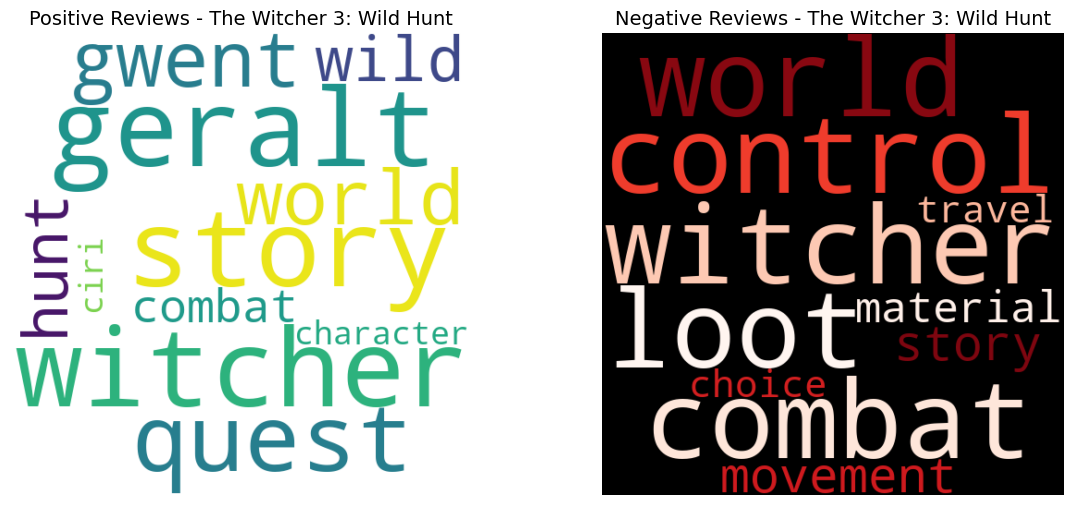

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Select a game for visualization
selected_game = "The Witcher 3: Wild Hunt"  # Change this to any game you want

# Extract positive and negative words for the selected game
game_data = df_top_words[df_top_words["Game"] == selected_game]

if not game_data.empty:
    pos_words = game_data["Top_Positive_Words"].values[0]
    neg_words = game_data["Top_Negative_Words"].values[0]

    # Convert lists to space-separated strings
    pos_text = " ".join(pos_words)
    neg_text = " ".join(neg_words)

    # Create figure for side-by-side word clouds
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Generate Positive Word Cloud
    wordcloud_pos = WordCloud(width=500, height=500, background_color="white").generate(pos_text)
    axes[0].imshow(wordcloud_pos, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"Positive Reviews - {selected_game}", fontsize=14)

    # Generate Negative Word Cloud
    wordcloud_neg = WordCloud(width=500, height=500, background_color="black", colormap="Reds").generate(neg_text)
    axes[1].imshow(wordcloud_neg, interpolation="bilinear")
    axes[1].axis("off")
    axes[1].set_title(f"Negative Reviews - {selected_game}", fontsize=14)

    # Show the word clouds
    plt.show()
else:
    print(f"No data found for {selected_game}")


In [15]:
# Creating a DataFrame with extended user reviews
user_reviews = pd.DataFrame({
    "Game": [
        "The Witcher 3: Wild Hunt", 
        "Dark Souls 3", 
        "X-Morph: Defense", 
        "Cyberpunk 2077", 
        "Horizon Zero Dawn",
        "Assassin’s Creed Valhalla"
    ],
    "review": [
        "I really enjoyed The Witcher 3 because of its vast open world, deep story, and breathtaking graphics. The game offers an immersive experience with well-developed characters and rich lore. The combat mechanics feel smooth, and there are countless side quests that add depth to the world. However, it required a very strong PC, and I experienced frequent crashes, which sometimes ruined the immersion.",
        
        "Dark Souls 3 was an amazing experience. The quest design is intricate, and the story, though subtle, is deeply engaging for those who invest time in understanding the lore. The combat is extremely challenging but rewarding, requiring precision and strategy. The boss fights are intense and satisfying, though some of them felt repetitive. Additionally, certain difficulty spikes felt unbalanced, making progression frustrating at times.",
        
        "I did not like X-Morph: Defense because it's a tower defense game, and I’m not into that genre. The game lacks a compelling story, and the graphics felt outdated compared to modern strategy games. The gameplay quickly became repetitive, and there wasn't much variety in the mechanics. It didn’t hold my interest for long, and I found myself getting bored after a few levels.",
        
        "Cyberpunk 2077 had a lot of potential with its futuristic open world and deep RPG mechanics. The city felt alive with plenty of characters and side quests. However, the game was plagued with technical issues, including game-breaking bugs, crashes, and unoptimized performance. While the main story was engaging, the overall experience was disappointing due to the lack of polish at launch.",
        
        "Horizon Zero Dawn was an incredible game with a unique blend of open-world exploration, a strong protagonist, and a compelling sci-fi story. The combat felt dynamic, and the world was beautifully crafted with breathtaking landscapes. The enemy AI was intelligent, and each fight required strategy. The only downside was that some side missions felt repetitive after a while, but overall, it was an amazing experience.",
        
        "Assassin’s Creed Valhalla was an enjoyable game for the most part. The Viking setting was immersive, and the world was rich with details. The combat felt weighty, and there were plenty of things to do. However, I found the progression system to be too grindy, and the game felt repetitive after some time. The story, while engaging at first, started to lose its impact halfway through. The overall experience was decent but not exceptional."
    ],
    "recommended": [
        "True", 
        "True", 
        "False", 
        "False", 
        "True", 
        "False"
    ]
})
game_metadata = pd.DataFrame({
    "Game": ["The Witcher 3: Wild Hunt", "Dark Souls 3", "X-Morph: Defense", "Cyberpunk 2077", "Horizon Zero Dawn", "Assassin’s Creed Valhalla"],
    "genre": ["RPG, Open World", "Action, RPG", "Strategy, Tower Defense", "Action, RPG, Open World", "Action, Adventure", "Action, RPG"],
    "action": [False, True, False, True, True, True],
    "strategy": [False, False, True, False, False, False],
    "free_to_play": [False, False, False, False, False, False],
    "adventure": [True, False, False, True, True, True],
    "massively_multiplayer": [False, False, False, False, False, False],
    "indie": [False, False, False, False, False, False],
    "rpg": [True, True, False, True, True, True],
    "casual": [False, False, False, False, False, False],
    "racing": [False, False, False, False, False, False],
    "early_access": [False, False, False, False, False, False],
    "simulation": [False, False, False, False, False, False],
    "unknown_genre": [False, False, False, False, False, False],
    "sports": [False, False, False, False, False, False],
    "violent": [True, True, False, True, False, True],
    "education": [False, False, False, False, False, False],
    "utilities": [False, False, False, False, False, False]
})
user_reviews = user_reviews.merge(game_metadata, on="Game", how="left")

# Display the DataFrame
print(user_reviews)


                        Game  \
0   The Witcher 3: Wild Hunt   
1               Dark Souls 3   
2           X-Morph: Defense   
3             Cyberpunk 2077   
4          Horizon Zero Dawn   
5  Assassin’s Creed Valhalla   

                                              review recommended  \
0  I really enjoyed The Witcher 3 because of its ...        True   
1  Dark Souls 3 was an amazing experience. The qu...        True   
2  I did not like X-Morph: Defense because it's a...       False   
3  Cyberpunk 2077 had a lot of potential with its...       False   
4  Horizon Zero Dawn was an incredible game with ...        True   
5  Assassin’s Creed Valhalla was an enjoyable gam...       False   

                     genre  action  strategy  free_to_play  adventure  \
0          RPG, Open World   False     False         False       True   
1              Action, RPG    True     False         False      False   
2  Strategy, Tower Defense   False      True         False      False   
3  Act

In [16]:
import os
import re
import csv
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
import spacy
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

from scipy.stats import pearsonr

# Function to download NLTK resources
def download_nltk_resources():
    required_resources = ['wordnet', 'stopwords', 'punkt']
    for resource in required_resources:
        try:
            nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        except LookupError:
            nltk.download(resource)

download_nltk_resources()

# Function to install and load spaCy model
def install_spacy_model(model_name):
    try:
        return spacy.load(model_name)
    except OSError:
        print(f"Downloading spaCy model: {model_name}")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
        return spacy.load(model_name)

sp = install_spacy_model('en_core_web_sm')

# Enable tqdm for pandas
tqdm.pandas()

# Initialize stemmers and lemmatizer
porter = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to /home/oliver/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/oliver/miniconda3/envs/Textmining_2/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [17]:
"""
This module provides helper functions for text preprocessing. 
Each function applies punctuation removal and stopword removal, and then one of three options:
    0: Lowercasing only.
    1: Lowercasing plus stemming.
    2: Lemmatizing (using spaCy; original casing is preserved).

The functions return a string of tokens separated by spaces.
"""


def preprocess_lower(text):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation.
       - Tokenizing.
       - Removing stopwords.
    
    Returns:
        str: A string of filtered tokens separated by spaces.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)
    tokens = word_tokenize(text_no_punct)
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return " ".join(filtered_tokens)

def preprocess_stem(text):
    """
    Preprocess text by performing all steps in preprocess_lower() and then applying stemming.
    
    Returns:
        str: A string of stemmed tokens separated by spaces.
    """
    tokens = preprocess_lower(text).split()
    ps = PorterStemmer()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)


# Function to remove emojis and special characters
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove HTML-like tags [b], [i], etc.
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Keeps letters, numbers, and spaces
    return text

# Updated preprocess_lemma function
def preprocess_lemma(text):
    """
    Preprocess text by:
       - Removing special characters, emojis, and HTML tags.
       - Lemmatizing the text using spaCy.
       - Keeping only alphabetic words (removes numbers & symbols).
    
    Returns:
        str: A string of lemmatized words separated by spaces.
    """
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")
    text = clean_text(text)  # Remove special characters
    doc = nlp(text)  # Process text with spaCy
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]  # Keep only words
    return " ".join(lemmatized_tokens)



def tokenize(text, mode=0):
    """
    General tokenize function. Always applies punctuation and stopword removal and then:
    
      mode = 0: Applies lowercasing.
      mode = 1: Applies lowercasing and stemming.
      mode = 2: Applies lemmatization (without lowercasing the original text).
    
    Args:
        text (str): The input text to be processed.
        mode (int): Processing mode (0 for lowercasing; 1 for stemming; 2 for lemmatizing).

    Returns:
        str: A string of processed tokens separated by spaces.

    Raises:
        ValueError: If an invalid mode is provided.
    """
    if mode == 0:
        return preprocess_lower(text)
    elif mode == 1:
        return preprocess_stem(text)
    elif mode == 2:
        return preprocess_lemma(text)
    else:
        raise ValueError("Invalid mode. Please use 0 for lowercasing, 1 for stemming, or 2 for lemmatizing.")

In [18]:
#Getting the clean text column
mod=2 #Lemmatizing

# Pre-process the text column with progress tracking
try:
    user_reviews["cleaned_review"] = user_reviews["review"].progress_apply(lambda x: tokenize(str(x), mod))
    print("Done processing text.")
except Exception as e:
    print(f"Error processing text column: {e}")
    sys.exit(1)


  0%|          | 0/6 [00:00<?, ?it/s]/home/oliver/miniconda3/envs/Textmining_2/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

Done processing text.


In [19]:
pos_reviews_cleaned = user_reviews[user_reviews["recommended"] == "True"].copy()
neg_reviews_cleaned = user_reviews[user_reviews["recommended"] == "False"].copy()
pos_reviews_cleaned = pos_reviews_cleaned.dropna(subset=['cleaned_review'])
pos_reviews_cleaned["cleaned_review"] = pos_reviews_cleaned["cleaned_review"].apply(remove_custom_stopwords)

# Remove NaN values and apply custom stopwords removal for negative reviews
neg_reviews_cleaned = neg_reviews_cleaned.dropna(subset=['cleaned_review'])
neg_reviews_cleaned["cleaned_review"] = neg_reviews_cleaned["cleaned_review"].apply(remove_custom_stopwords)

vectorizer_pos = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)
vectorizer_neg = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)

# Step 3: Apply TF-IDF on positive reviews

user_pos_doc = " ".join(pos_reviews_cleaned["cleaned_review"])
tfidf_matrix_pos = vectorizer_pos.fit_transform([user_pos_doc])

terms_pos = vectorizer_pos.get_feature_names_out()

# Step 4: Apply TF-IDF on negative reviews

user_neg_doc = " ".join(neg_reviews_cleaned["cleaned_review"])
tfidf_matrix_neg = vectorizer_neg.fit_transform([user_neg_doc])
# TF-IDF scores for one document
terms_pos = vectorizer_pos.get_feature_names_out()
tfidf_sum_pos = tfidf_matrix_pos.toarray()[0]

terms_neg = vectorizer_neg.get_feature_names_out()
tfidf_sum_neg = tfidf_matrix_neg.toarray()[0]

# Create the DataFrames
tfidf_df_pos = pd.DataFrame({'term': terms_pos, 'tfidf_score': tfidf_sum_pos}).sort_values(by="tfidf_score", ascending=False)
tfidf_df_neg = pd.DataFrame({'term': terms_neg, 'tfidf_score': tfidf_sum_neg}).sort_values(by="tfidf_score", ascending=False)

# Step 7: Display the TF-IDF DataFrames
print("\nTop Positive User Profile TF-IDF Terms:\n", tfidf_df_pos.head(10))
print("\nTop Negative User Profile TF-IDF Terms:\n", tfidf_df_neg.head(10))


Top Positive User Profile TF-IDF Terms:
              term  tfidf_score
57     experience     0.253490
122       require     0.190117
23         combat     0.190117
142         story     0.190117
166         world     0.190117
14   breathtaking     0.126745
146      strategy     0.126745
65          fight     0.126745
116         quest     0.126745
119    repetitive     0.126745

Top Negative User Profile TF-IDF Terms:
                    term  tfidf_score
114               story     0.224231
103          repetitive     0.149487
64                 lack     0.149487
39           experience     0.149487
85   overall experience     0.149487
84              overall     0.149487
28              defense     0.149487
115        story engage     0.149487
90               plenty     0.149487
33               engage     0.149487


In [20]:
pos_reviews_cleaned

,Game,review,recommended,genre,action,strategy,free_to_play,adventure,massively_multiplayer,indie,...,casual,racing,early_access,simulation,unknown_genre,sports,violent,education,utilities,cleaned_review
0,The Witcher 3: Wild Hunt,I really enjoyed The Witcher 3 because of its ...,True,"RPG, Open World",False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,Witcher vast open world deep story breathtakin...
1,Dark Souls 3,Dark Souls 3 was an amazing experience. The qu...,True,"Action, RPG",True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,Dark Souls amazing experience quest design int...
4,Horizon Zero Dawn,Horizon Zero Dawn was an incredible game with ...,True,"Action, Adventure",True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,Horizon Zero Dawn incredible unique blend open...


tfidf_df_pos = positive terms from the User

tfidf_df_neg = negative terms from the User

df_top_words = terms for all games, pos and negative.


In [21]:
# Convert TF-IDF dataframes into dictionaries for fast lookup
user_pos_profile = dict(zip(tfidf_df_pos["term"], tfidf_df_pos["tfidf_score"]))
user_neg_profile = dict(zip(tfidf_df_neg["term"], tfidf_df_neg["tfidf_score"]))

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to compute cosine similarity between two TF-IDF vectors
def compute_cosine_similarity(user_profile, game_profile):
    # Create aligned vectors (matching words in both profiles)
    all_terms = set(user_profile.keys()).union(set(game_profile.keys()))

    # Convert profiles into numerical vectors
    user_vector = np.array([user_profile.get(term, 0) for term in all_terms])
    game_vector = np.array([game_profile.get(term, 0) for term in all_terms])

    # Compute cosine similarity
    similarity = cosine_similarity([user_vector], [game_vector])[0][0]
    return similarity




In [22]:
game_similarity_scores = []
# Replace any NaNs in the word columns with empty lists
df_top_words["Top_Positive_Words"] = df_top_words["Top_Positive_Words"].apply(lambda x: x if isinstance(x, list) else [])
df_top_words["Top_Negative_Words"] = df_top_words["Top_Negative_Words"].apply(lambda x: x if isinstance(x, list) else [])

# Iterate through each game and compute similarity
for index, row in df_top_words.iterrows():
    game_name = row["Game"]

    # Convert game terms into dictionaries
    game_pos_profile = dict(zip(row["Top_Positive_Words"], [1]*len(row["Top_Positive_Words"])))
    game_neg_profile = dict(zip(row["Top_Negative_Words"], [1]*len(row["Top_Negative_Words"])))

    # Compute cosine similarity with user profile
    pos_sim = compute_cosine_similarity(user_pos_profile, game_pos_profile)
    neg_sim = compute_cosine_similarity(user_neg_profile, game_neg_profile)

    # Calculate final score (favor positive similarity, penalize negative similarity)
    final_score = pos_sim - neg_sim

    # Store results
    game_similarity_scores.append((game_name, pos_sim, neg_sim, final_score))

# Convert to DataFrame
df_game_recommendations = pd.DataFrame(game_similarity_scores, columns=["Game", "Positive_Similarity", "Negative_Similarity", "Final_Score"])

# Sort by final score
df_game_recommendations = df_game_recommendations.sort_values(by="Final_Score", ascending=False)

df_game_recommendations.head(10)


,Game,Positive_Similarity,Negative_Similarity,Final_Score
69,Red Dead Redemption 2,0.160321,0.000000,0.160321
8,Atomic Heart,0.180361,0.023636,0.156725
26,Cyberpunk 2077,0.140281,0.000000,0.140281
44,Fallout 4,0.160321,0.023636,0.136685
86,The Witcher 3: Wild Hunt,0.260522,0.141816,0.118706
51,Kingdom Come: Deliverance II,0.160321,0.047272,0.113049
45,Far Cry® 4,0.100201,0.000000,0.100201
92,Valheim,0.100201,0.000000,0.100201
71,Robin Hood - Sherwood Builders,0.100201,0.000000,0.100201
49,Grand Theft Auto V Legacy,0.080160,0.000000,0.080160


We can see how most of the recommended games make sense, but not all of them.
What is very interesting is that we actually recommend The Witcher 3: Wild Hunt, which is a game that we reviewed as positively recommended.
This makes sense but it should nevertheless not happen so we take it out of range of predictions:

In [23]:
# Remove games that the user has already reviewed from recommendations
df_filtered_recommendations = df_game_recommendations[~df_game_recommendations["Game"].isin(user_reviews["Game"])]

# Display the updated recommendations without already-reviewed games
df_filtered_recommendations.head(10)


,Game,Positive_Similarity,Negative_Similarity,Final_Score
69,Red Dead Redemption 2,0.160321,0.000000,0.160321
8,Atomic Heart,0.180361,0.023636,0.156725
44,Fallout 4,0.160321,0.023636,0.136685
51,Kingdom Come: Deliverance II,0.160321,0.047272,0.113049
45,Far Cry® 4,0.100201,0.000000,0.100201
92,Valheim,0.100201,0.000000,0.100201
71,Robin Hood - Sherwood Builders,0.100201,0.000000,0.100201
49,Grand Theft Auto V Legacy,0.080160,0.000000,0.080160
70,Resident Evil 4,0.080160,0.000000,0.080160
91,Unknown Game,0.080160,0.000000,0.080160


### Improving Predictions

To improve our predictions furthermore, we will include the strategy boolean.

Let's recap what dataframes we still have and can use for this process:


In [24]:
user_reviews.head() #Remember we still have our dataframe of user reviews, so let's use the extra features!

,Game,review,recommended,genre,action,strategy,free_to_play,adventure,massively_multiplayer,indie,...,casual,racing,early_access,simulation,unknown_genre,sports,violent,education,utilities,cleaned_review
0,The Witcher 3: Wild Hunt,I really enjoyed The Witcher 3 because of its ...,True,"RPG, Open World",False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,enjoy Witcher vast open world deep story breat...
1,Dark Souls 3,Dark Souls 3 was an amazing experience. The qu...,True,"Action, RPG",True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,Dark Souls amazing experience quest design int...
2,X-Morph: Defense,I did not like X-Morph: Defense because it's a...,False,"Strategy, Tower Defense",False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,like XMorph Defense tower defense game m genre...
3,Cyberpunk 2077,Cyberpunk 2077 had a lot of potential with its...,False,"Action, RPG, Open World",True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,cyberpunk lot potential futuristic open world ...
4,Horizon Zero Dawn,Horizon Zero Dawn was an incredible game with ...,True,"Action, Adventure",True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,Horizon Zero Dawn incredible game unique blend...


Let's create a feature profile.

We simply calculate a score based on the average of each strategy, effectively saying how much each genre matters for the gamer.

In [25]:
# Define lambda (weighting for feature matching)
lambda_weight = 0.5  # Adjust based on preference (higher = genre matters more)
user_reviews["recommended"] = user_reviews["recommended"].astype(bool)
# Compute the user's preferred feature profile
user_feature_profile = user_reviews[user_reviews["recommended"] == True].drop(
    columns=["Game", "review", "recommended", "genre", "cleaned_review"]
).mean() #we take the mean to normalize the sum


In [26]:
user_feature_profile

action                   0.666667
strategy                 0.166667
free_to_play             0.000000
adventure                0.666667
massively_multiplayer    0.000000
indie                    0.000000
rpg                      0.833333
casual                   0.000000
racing                   0.000000
early_access             0.000000
simulation               0.000000
unknown_genre            0.000000
sports                   0.000000
violent                  0.666667
education                0.000000
utilities                0.000000
dtype: float64

Seems like action, rpg, adventour is most important to him or her!

To include this in our similarity score, we need the genre booleans in our recommendation dataframe as well. Remember that it just included Game, Similarity and Score?
This is why we join it with the unique game_reviews below! 

In [27]:
genre_columns = ["Game", "action", "strategy", "free_to_play", "adventure", 
                 "massively_multiplayer", "indie", "rpg", "casual", "racing", 
                 "early_access", "simulation", "unknown_genre", "sports", 
                 "violent", "education", "utilities"] #these are exactly the same as the ones in our dataframe of game_reviews

unique_game_features = game_reviews[genre_columns].drop_duplicates(subset=["Game"]) #We only need the infortmation of 1 review per game

# Merge df_filtered_recommendations with unique game metadata
df_filtered_recommendations = df_filtered_recommendations.merge(
    unique_game_features, on="Game", how="left"
)
#including all games:
df_game_recommendations = df_game_recommendations.merge(
    unique_game_features, on="Game", how="left"
)


In [28]:
df_filtered_recommendations.head()

,Game,Positive_Similarity,Negative_Similarity,Final_Score,action,strategy,free_to_play,adventure,massively_multiplayer,indie,rpg,casual,racing,early_access,simulation,unknown_genre,sports,violent,education,utilities
0,Red Dead Redemption 2,0.160321,0.000000,0.160321,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,Atomic Heart,0.180361,0.023636,0.156725,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
2,Fallout 4,0.160321,0.023636,0.136685,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,Kingdom Come: Deliverance II,0.160321,0.047272,0.113049,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
4,Far Cry® 4,0.100201,0.000000,0.100201,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [29]:
df_game_recommendations.head() #We initially worked with df_filtered_recommendations, but we decided to not filter for performance evaluations as described above.

,Game,Positive_Similarity,Negative_Similarity,Final_Score,action,strategy,free_to_play,adventure,massively_multiplayer,indie,rpg,casual,racing,early_access,simulation,unknown_genre,sports,violent,education,utilities
0,Red Dead Redemption 2,0.160321,0.000000,0.160321,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,Atomic Heart,0.180361,0.023636,0.156725,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
2,Cyberpunk 2077,0.140281,0.000000,0.140281,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,Fallout 4,0.160321,0.023636,0.136685,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,The Witcher 3: Wild Hunt,0.260522,0.141816,0.118706,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [30]:
#df_filtered_recommendations=df_game_recommendations.copy() #however, we will work with df_game_recommendations without filters below!

### Computing the Feature Score

To work with this, we will extract the booleans and convert into a numpy vector to work with it.

In [31]:
game_features_matrix = df_filtered_recommendations.drop(
    columns=["Game", "Positive_Similarity", "Negative_Similarity", "Final_Score"], errors="ignore"
).values

user_feature_vector = user_feature_profile.values

As we have a matrix and a vector and we want to compare the row (each game) with the vector of the user, we can compute the dot product. The dot product acts as a kind of similiarity measure (the higher the more similiar), so we can apply this and efficiently compute the final feature score!

In [32]:
genre_columns = list(user_feature_profile.index)  # we only have 16 genres in user column so we need to make it match teh game genres (not needed in real life)

# Now select just those columns from the recommendations
game_features_matrix = df_filtered_recommendations[genre_columns].values
user_feature_vector = user_feature_profile.values

# Compute dot product
df_filtered_recommendations["Feature_Match_Score"] = np.dot(game_features_matrix, user_feature_vector)

Lastly, we put all three scores together: Positive Similiarity, Negative Similarity and Feature Match Score:

This results into a **new Final_Score**, including not only the similarity from before but also the genre features!

In [33]:
df_filtered_recommendations["Final_Score"] = (
    df_filtered_recommendations["Positive_Similarity"] 
    - df_filtered_recommendations["Negative_Similarity"]
    + lambda_weight * df_filtered_recommendations["Feature_Match_Score"]  # we use the same lambda as before!
)

# Step 3: Sort and display new recommendations
df_filtered_recommendations = df_filtered_recommendations.sort_values(by="Final_Score", ascending=False)

df_filtered_recommendations.head(10)


,Game,Positive_Similarity,Negative_Similarity,Final_Score,action,strategy,free_to_play,adventure,massively_multiplayer,indie,...,casual,racing,early_access,simulation,unknown_genre,sports,violent,education,utilities,Feature_Match_Score
1,Atomic Heart,0.180361,0.023636,1.240058,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,2.166667
3,Kingdom Come: Deliverance II,0.160321,0.047272,1.196382,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,2.166667
5,Valheim,0.100201,0.000000,1.183534,True,False,False,True,False,True,...,False,False,True,False,False,False,False,False,False,2.166667
72,Elite Dangerous,0.000000,0.000000,1.166667,True,True,False,True,True,False,...,False,False,False,True,False,False,False,False,False,2.333333
19,Exanima,0.060120,0.000000,1.143454,True,False,False,True,False,True,...,False,False,True,True,False,False,False,False,False,2.166667
24,Terraria,0.040080,0.000000,1.123414,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,2.166667
29,Yakuza 0,0.120241,0.094544,1.109030,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,2.166667
32,"Warhammer 40,000: Space Marine 2",0.020040,0.000000,1.103373,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,2.166667
37,ARK: Survival Ascended,0.040080,0.023636,1.099778,True,False,False,True,True,True,...,False,False,True,False,False,False,False,False,False,2.166667
55,0 Day,0.000000,0.000000,1.083333,True,True,False,True,False,True,...,False,False,True,False,False,False,True,False,False,2.166667


We can see how our predictions changed quite a bit! This heavily depends on or weight parameter alpha. After playing around a bit, we decided that 0.5 would be a good fit however, since the results make a lot of sense with it. For example, the game "Kingdom Come" is still included in our final predictions, but we can see how some other games like  Elite Dangerous appeared quite high in the list, which did not appear in our original recommendations but do appear now!

However, judging the performance for this system is the most challenging part of such game recommendation systems. So in general it is very difficult to say how well this system performans, but more on that can be read in the report.

## Performance Evaluation

As described in the report, evaluating performance is not as straightforward as in ordingary ML algorithms but some usefull information will be plotted and described below.

### Plots

In some way, we can check how our system performs by analyziing how strongly games in the final recommendations match the user’s profile. If scores are high, it indicates very close matches. if scores are low, it indicates that the model could maybe be improved.

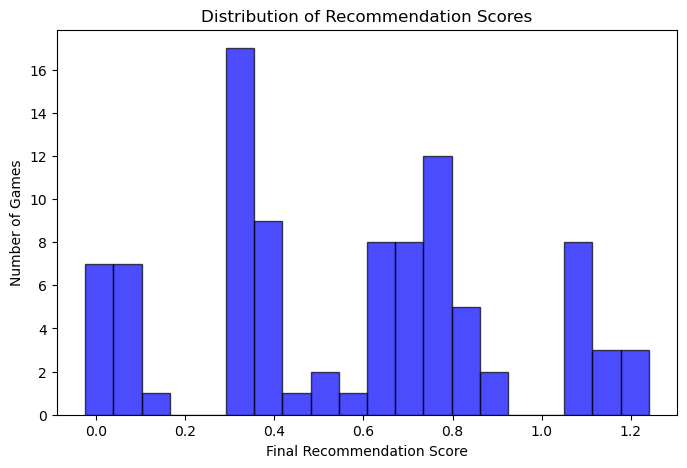

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Histogram of similarity scores in recommendations
plt.figure(figsize=(8, 5))
plt.hist(df_filtered_recommendations["Final_Score"], bins=20, alpha=0.7, color="blue", edgecolor="black")
plt.xlabel("Final Recommendation Score")
plt.ylabel("Number of Games")
plt.title("Distribution of Recommendation Scores")
plt.show()


In [35]:
from scipy.stats import spearmanr

# Compute correlation between user feature profile and recommended game features
feature_columns = ["action", "strategy", "free_to_play", "adventure", "massively_multiplayer",
                   "indie", "rpg", "casual", "racing", "early_access", "simulation",
                   "unknown_genre", "sports", "violent", "education", "utilities"]

# Compute Spearman rank correlation
correlations = {}
for feature in feature_columns:
    correlation, _ = spearmanr(df_filtered_recommendations[feature], df_filtered_recommendations["Final_Score"])
    correlations[feature] = correlation

# Sort by highest correlation
correlations = dict(sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True))

# Print correlations
print("Correlation between Features & Final Score:\n")
for feature, corr in correlations.items():
    print(f"{feature}: {corr:.3f}")


Correlation between Features & Final Score:

adventure: 0.736
rpg: 0.684
action: 0.395
massively_multiplayer: 0.288
sports: -0.240
education: -0.167
utilities: -0.167
early_access: 0.150
unknown_genre: -0.147
violent: 0.140
free_to_play: -0.138
strategy: -0.137
racing: -0.118
simulation: -0.099
indie: 0.061
casual: 0.013


/tmp/ipykernel_113997/3242741047.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_filtered_recommendations["Positive_Similarity"], label="Positive Similarity", shade=True, color="green")
/tmp/ipykernel_113997/3242741047.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_filtered_recommendations["Negative_Similarity"], label="Negative Similarity", shade=True, color="red")


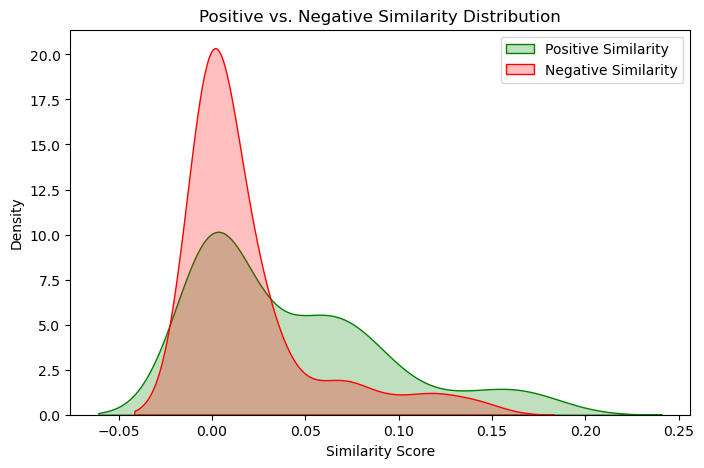

In [36]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(df_filtered_recommendations["Positive_Similarity"], label="Positive Similarity", shade=True, color="green")
sns.kdeplot(df_filtered_recommendations["Negative_Similarity"], label="Negative Similarity", shade=True, color="red")
plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.title("Positive vs. Negative Similarity Distribution")
plt.legend()
plt.show()


### Adaptive Feedback System

As the reviews are written by myself and I can tell which games I like or equivalently which recommendations I like, I decide to "approve" / "like" the following recommendations:

**"Kingdom Come: Deliverance II", "Elite Dangerous", "Crusader Kings III"**

However, the recommendatino **"Rust"** does not seem very relevant to me. I dislike it.

This means we give these game a higher/lower weight in our feature mapping, adjusting the final score!

In [37]:
# Example: User liked "Sekiro" but disliked "Mafia"
liked_games = ["Kingdom Come: Deliverance II", "Elite Dangerous", "Crusader Kings III"]
disliked_games = ["Rust"]

# Adjust the user feature profile
for game in liked_games:
    game_features = df_filtered_recommendations[df_filtered_recommendations["Game"] == game][user_feature_profile.index]
    user_feature_profile += game_features.mean() * 0.1  # Increase weight for liked game features

for game in disliked_games:
    game_features = df_filtered_recommendations[df_filtered_recommendations["Game"] == game][user_feature_profile.index]
    user_feature_profile -= game_features.mean() 

After this, we have to recompute everything again.

#### Recomputations

In [38]:
# Recompute TF-IDF profiles after user feedback
user_pos_profile = dict(zip(tfidf_df_pos["term"], tfidf_df_pos["tfidf_score"]))
user_neg_profile = dict(zip(tfidf_df_neg["term"], tfidf_df_neg["tfidf_score"]))

game_similarity_scores = []
for index, row in df_top_words.iterrows():
    game_name = row["Game"]
    
    game_pos_profile = dict(zip(row["Top_Positive_Words"], [1]*len(row["Top_Positive_Words"])))
    game_neg_profile = dict(zip(row["Top_Negative_Words"], [1]*len(row["Top_Negative_Words"])))

    pos_sim = compute_cosine_similarity(user_pos_profile, game_pos_profile)
    neg_sim = compute_cosine_similarity(user_neg_profile, game_neg_profile)

    final_score = pos_sim - neg_sim

    game_similarity_scores.append((game_name, pos_sim, neg_sim, final_score))

df_game_recommendations = pd.DataFrame(
    game_similarity_scores, 
    columns=["Game", "Positive_Similarity", "Negative_Similarity", "Final_Score"]
)

df_game_recommendations = df_game_recommendations.sort_values(by="Final_Score", ascending=False)


df_game_recommendations = df_game_recommendations.merge(
    unique_game_features, on="Game", how="left"
)

game_features_matrix = df_game_recommendations.drop(
    columns=["Game", "Positive_Similarity", "Negative_Similarity", "Final_Score"], errors="ignore"
).values

df_game_recommendations["Feature_Match_Score"] = np.dot(game_features_matrix, user_feature_profile)

df_game_recommendations["Final_Score"] = (
    df_game_recommendations["Positive_Similarity"] 
    - df_game_recommendations["Negative_Similarity"]
    + lambda_weight * df_game_recommendations["Feature_Match_Score"]
)

df_game_recommendations = df_game_recommendations.sort_values(by="Final_Score", ascending=False)

df_game_recommendations


,Game,Positive_Similarity,Negative_Similarity,Final_Score,action,strategy,free_to_play,adventure,massively_multiplayer,indie,...,casual,racing,early_access,simulation,unknown_genre,sports,violent,education,utilities,Feature_Match_Score
40,Crusader Kings III,0.040080,0.023636,0.366444,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,0.700000
38,Europa Universalis IV,0.040080,0.023636,0.299778,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,0.566667
27,Age of Empires IV: Anniversary Edition,0.040080,0.000000,0.223414,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.366667
30,Baldur's Gate 3,0.080160,0.047272,0.216222,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,0.366667
2,Cyberpunk 2077,0.140281,0.000000,0.206948,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Cursed to Golf,0.000000,0.000000,-0.633333,True,False,False,True,False,True,...,False,False,False,False,False,True,False,False,False,-1.266667
39,ARK: Survival Ascended,0.040080,0.023636,-1.000222,True,False,False,True,True,True,...,False,False,True,False,False,False,False,False,False,-2.033333
56,Rust,0.000000,0.000000,-1.016667,True,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,-2.033333
92,ARK: Survival Evolved,0.000000,0.023636,-1.040303,True,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,-2.033333


As we can see, our system succesfully changed and adapted to our Likings: "Crusader Kings III" is now top 1.
Also notice how the other entries changed, since everything changes that involves the same genres. This is important to notice since this is what we care about. Most of the recommended games change, just because of this small update!